In [1]:
import os
from os import listdir
from os.path import isfile, join
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2

Old Data loading - from google drive

from google.colab import drive
drive.mount('/content/drive')
fpath = 'drive/My Drive/DL_Project/FV-Cells/Policristal'

# Model of Autoencoder

In [2]:

class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

    # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
    

    # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
                            name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

In [3]:
# Load the Cracks and Fingers folder files
pth_C = 'FV-Cells/Policristal/Full_Defected'
pth_G = 'FV-Cells/Policristal/Full_Undefected'

files_C = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_C)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]
files_G = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_G)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

print('Train::')
print(f'Cracks files = {len(files_C)} and Good files = {len(files_G)}')

Train::
Cracks files = 32 and Good files = 23


FV-Cells/Policristal/Full_Defected\1126.bmp (964, 968)


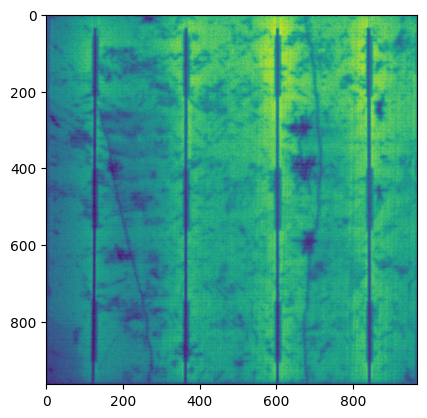

In [4]:
# Show one random example of the Cracks img, the number 16 in this case
fname = files_C[15]
img = cv2.imread(fname,0)
print(fname, img.shape)
plt.imshow(img)
plt.show()

# Creating the convolutional autoencoder training script

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [6]:
# This function segments each Crack/Finger img and its ROI
  # Then it calculates how many pixels in the ROI segment are in red (correspond to a Crack/Finger)
  # Finally with a value/threshold it defines if this segment is a good or bad

#--------------------------------------
### IMAGE PROCESSING && SAVING
def img_procc(fname,overlap=0.6,type='All'):
    new_w = 64 #256 #128 #64 # 150
    new_h = 64 #256 #128 #64 # 150
    #overlap = 0.6
    tki,tkj = 5, 5 # take 1 out of 4 images
    cnti,cntj = 5, 5
    imgs_G = []
    imgs_B = []
    
    img = cv2.imread(fname,0)
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = img*1./255
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    img_ROI = []
    
    #DEFINE SAVE PATH
    ROI=find_ROI_img(fname)
    #print(ROI[0])
    if ROI!=None:
        img_ROI = cv2.imread(ROI[0],0) 
        img_ROI = 1-(img_ROI/255)
    
    w_len = 0
    
    for i,vali in enumerate(range(0,img_w,int(new_w - overlap*new_w))):
        cnti=cnti+1
        if cnti>tki:
            cnti = 0
            h_len = 0 
            if w_len != 1: #NO estamos en la esquina de la figura
                for j,valj in enumerate(range(0,img_h,int(new_h - overlap*new_h))):
                    cntj=cntj+1
                    if cntj>tkj:
                        cntj = 0
                        if h_len != 1: # NO estamos en la esquina de la figura
                            #take img
                            w_rng = [vali, vali+new_w]
                            h_rng = [valj, valj+new_h]
                            if (vali+new_w > img_w):
                                w_len=1 #estamos en la esquina de la figura
                                w_rng = [img_w-new_w, img_w]
                            if (valj+new_h > img_h):
                                h_len=1    
                                h_rng = [img_h-new_h, img_h]

                            new_img = img[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                            bad = 0

                            otro = 0 #para genera otras copias en errores

                            if ROI==None:
                                #overlap = 0.3
                                dnm,fnm = os.path.split(fname)
                            else:
                                dnm,fnm = os.path.split(fname)
                                
                                img_ROI_tmp = img_ROI[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                                if img_ROI_tmp.sum()>10: #250:
                                    otro = 1
                                    if type!='None':
                                        cnti = tki+2 #para que coja los errores más veces que los que no.
                                        cntj = tkj+2 
                                    #overlap = 0.6
                                    bad = 1

                            if bad==0 and (type=='Good' or type=='All'):
                                #print('Good')
                                imgs_G.append(new_img)
                                
                                rows,cols = new_img.shape
                                #M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
                                #dst1 = cv2.warpAffine(new_img,M,(cols,rows))
                                #imgs_G.append(dst1)
                                imgs_G.append(new_img.transpose())
                            
                            elif bad==1 and (type=='Bad' or type=='All'):
                                #print('fallo')
                                imgs_B.append(new_img)
                                
                                rows,cols = new_img.shape
                                #M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
                                #dst1 = cv2.warpAffine(new_img,M,(cols,rows))
                                #imgs_B.append(dst1)
                                imgs_B.append(new_img.transpose())
                            
                            elif type=='None':
                                imgs_G.append(new_img)
                                
    return imgs_G, imgs_B
                            

def find_ROI_img(fname):
    dnm,fnm = os.path.split(fname)
    ROI_fnm = os.path.splitext(fnm)[0]+'_ROI.bmp'  
    ROI_pth = os.path.join(dnm,ROI_fnm)
    if os.path.isfile(ROI_pth):
        return ROI_pth,fnm

In [7]:
# With the function previously defined it segment the original img-s Crack/Fingers and create 3 datasets, GoodX, CrackX and FingerX
  # Depending which path img-s you use, the bad ones are CrackX or FingerX, while the good ones are always GoodX
new_size = [64, 64] #[32, 32]
GoodX =[]
CrackX = []

for val,fname in enumerate(files_C):
    #print(val, ' :: ', fname)
    imgs_G, imgs_B = img_procc(fname,type='All')
    for im in imgs_G:
        GoodX.append(im)
    for im in imgs_B:
        CrackX.append(im)
    
for val,fname in enumerate(files_G):
    #print(val, ' :: ', fname)
    imgs_G, imgs_B = img_procc(fname,type='All')
    for im in imgs_G:
        GoodX.append(im)
    for im in imgs_B:
        GoodX.append(im)
    
GoodX = np.asarray(GoodX)
GoodX = np.expand_dims(GoodX, axis=-1)
GoodX = GoodX.astype("float32") / 255.0
ids_G = np.arange(GoodX.shape[0])
np.random.shuffle(ids_G)
GoodX = GoodX[ids_G]

CrackX = np.asarray(CrackX)
CrackX = np.expand_dims(CrackX, axis=-1)
CrackX = CrackX.astype("float32") / 255.0
ids_C = np.arange(CrackX.shape[0])
np.random.shuffle(ids_C)
CrackX = CrackX[ids_C]


In [8]:
print('Good segment shape:')
print(GoodX.shape)
print('Crack segment shape:')
print(CrackX.shape)

Good segment shape:
(8286, 64, 64, 1)
Crack segment shape:
(2630, 64, 64, 1)


In [17]:
# Define function to plot the train dataset
def plot_list(idxs, imgs):
    columns = 10
    rows = int(np.ceil(len(idxs)/columns))
    images = np.zeros((rows * imgs.shape[1],columns*imgs.shape[2]))

    for j,ids in enumerate(idxs):

        row = int(np.floor(j/columns))
        column = j%columns

        images[row*new_size[0]:(row+1)*new_size[0], column*new_size[1]:(column+1)*new_size[1]] = imgs[ids,:,:,0]

    plt.figure(figsize=(20,10))
    plt.imshow(images)
    plt.show()

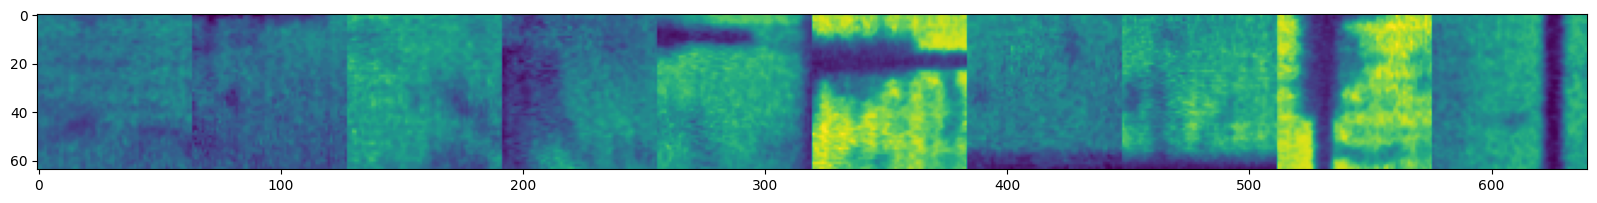

In [18]:
# Use the previous function to plot the Train dataset
st=40
ids_G = np.arange(GoodX.shape[0])
np.random.shuffle(ids_G)
plot_list(ids_G[st:st+10], GoodX)

In [ ]:
# Separate the Good segments in Train/Test
percentage_train = 0.8 # The percentage of Train data from Good segments
percentage_test = 1-percentage_train # The percentage of Test data from Good segments

# Calculate the number of Train_data
n_train = int(percentage_train*len(GoodX))

# Separate data in Train/Test
train_data = GoodX[:(n_train-1),:,:,0]
test_data = GoodX[(n_train-1):,:,:,0]

print('GoodX shape:')
print(GoodX.shape)
print('Train shape:')
print(train_data.shape)
print('Test shape:')
print(test_data.shape)

GoodX shape:
(8286, 64, 64, 1)
Train shape:
(6627, 64, 64)
Test shape:
(1659, 64, 64)


In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoderAN, decoderAN, autoencoderAN) = ConvAutoencoder.build(64, 64, 1)
opt = keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoderAN.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoderAN.fit(
	train_data, train_data,
	validation_data=(test_data, test_data),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...


c:\Users\01122464\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
208/208 [==============================] - 49s 229ms/step - loss: 0.0076 - val_loss: 0.0304
Epoch 2/25
208/208 [==============================] - 47s 228ms/step - loss: 0.0025 - val_loss: 0.0263
Epoch 3/25
208/208 [==============================] - 48s 230ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 4/25
208/208 [==============================] - 48s 231ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/25
208/208 [==============================] - 48s 230ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 6/25
208/208 [==============================] - 48s 232ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 7/25
208/208 [==============================] - 48s 233ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/25
208/208 [==============================] - 47s 227ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/25
208/208 [==============================] - 47s 227ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 10/25
208/208 [==============================] - 47s 227ms/step - l

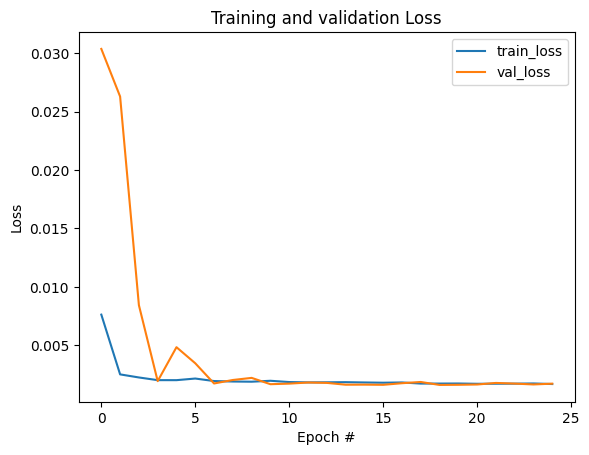

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
#plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

83/83 [==============================] - 6s 75ms/step


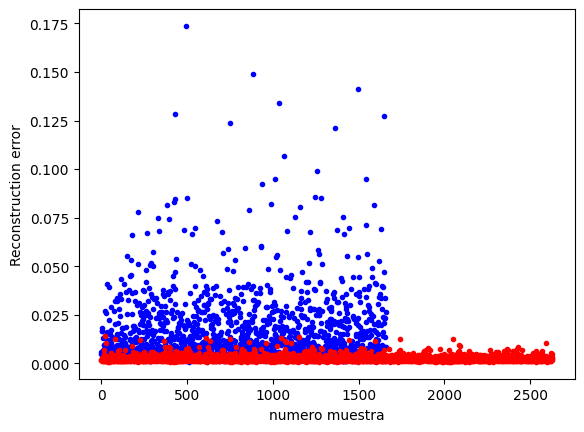

In [ ]:
errors_test = []
errors_Crack = []
errors_Finger = []

decoded_test = autoencoderAN.predict(test_data)
decoded_Crack = autoencoderAN.predict(CrackX)

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(test_data, decoded_test):
  # compute the mean squared error between the ground-truth image
  # and the reconstructed image, then add it to our list of errors
  mse = np.mean((image - recon) ** 2)
  errors_test.append(mse)

for (image, recon) in zip(CrackX, decoded_Crack):
  # compute the mean squared error between the ground-truth image
  # and the reconstructed image, then add it to our list of errors
  mse = np.mean((image - recon) ** 2)
  errors_Crack.append(mse)

 
#print(errors)
# Plot the error obtain with each original/rebuilt img to define the threshold
plt.plot(errors_test,'.b')
plt.plot(errors_Crack,'.r')
#legend('Test_data','Crack','Finger')
plt.xlabel('numero muestra')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
from numpy import zeros, newaxis
#--------------------------------------
### IMAGE PROCESSING && SAVING
def anomaly_det(fname,des_pix,type='All'):
    new_w = 64 #256 #128 #64 # 150
    new_h = 64 #256 #128 #64 # 150

    img = cv2.imread(fname,0)
    #img = cv2.GaussianBlur(img,(5,5),0)
    # With the CLAHE we see the img histogram and we spand it from 0 to x(255 in this case) to increase the contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = img*1./255

    # Create two matrix with img dimension
      # First to add the error probabilities of each segment
      # Second to calculate each pixel how many times is analyzed
    Matrix_cont = np.zeros(shape=(img.shape)) # Count matrix
    Matrix_prob = np.zeros(shape=(img.shape)) # Probability matrix
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    # i the iteration number, 0, 1, 2, 3, ....
    # vali it has a value depending on the range, if range(10,20,2), from 10 to 20 each, vali = 10, 12, 14, 16, ....
    for i,row in enumerate(range(0,img_w,des_pix)):
      ini_row = row
      fin_row = row+new_w
      if fin_row>=img_w:
        ini_row = img_w-new_w
        fin_row = img_w
      
      for j,col in enumerate(range(0,img_h,des_pix)):
        ini_col = col
        fin_col = col+new_h
        if fin_col>=img_h:
          ini_col = img_h-new_h
          fin_col = img_h

        new_img = img[ini_row:fin_row, ini_col:fin_col]
        # Change the new_img dimension to adjust to the model
        new_img = new_img[newaxis,:,:,newaxis]
        new_img = new_img.astype("float32") / 255.0

        errors = []

        recons = autoencoderAN.predict(new_img)

        # compute the mean squared error between the ground-truth image
        # and the reconstructed image, then add it to our list of errors
        mse = np.mean((new_img - recons) ** 2)
        errors.append(mse)

        # Add the error value in the corresponding matrix places
        Matrix_cont[ini_row:fin_row, ini_col:fin_col] = Matrix_cont[ini_row:fin_row, ini_col:fin_col]+1
        Matrix_prob[ini_row:fin_row, ini_col:fin_col] = Matrix_prob[ini_row:fin_row, ini_col:fin_col]+errors

        # Change 0 values of the Matrix_cont with 1s, to avoid x/0=nan
        ind_cero = Matrix_cont==0
        Matrix_cont[ind_cero] = 1

        prob_med = np.divide(Matrix_prob, Matrix_cont)
        prob_med.astype("float32")
    return prob_med

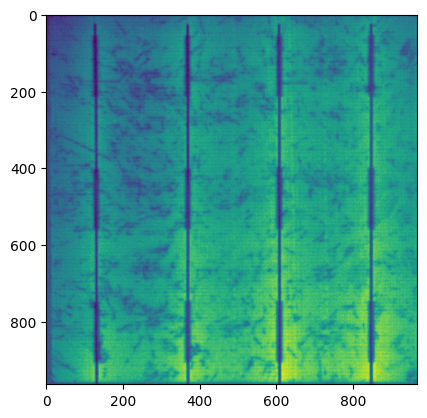

1/1 [==============================] - 0s 22ms/step


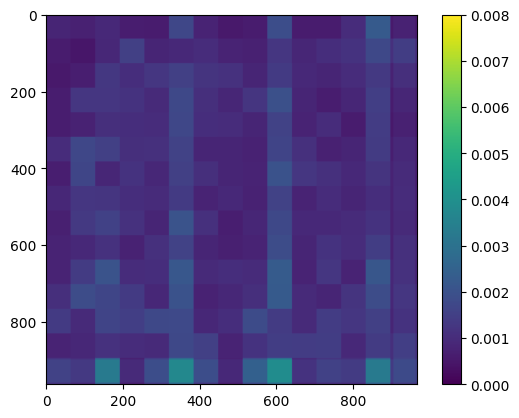

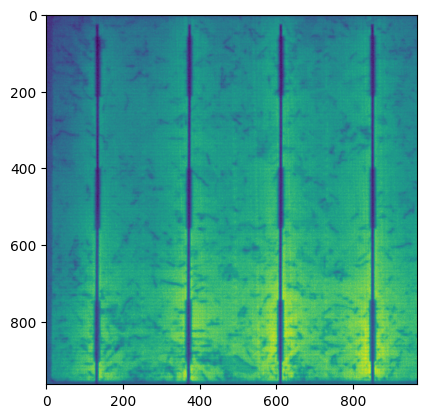

1/1 [==============================] - 0s 24ms/step


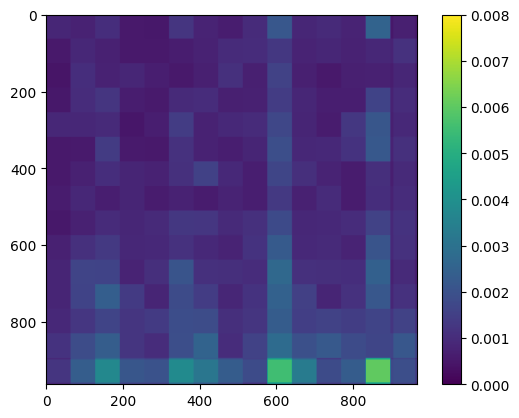

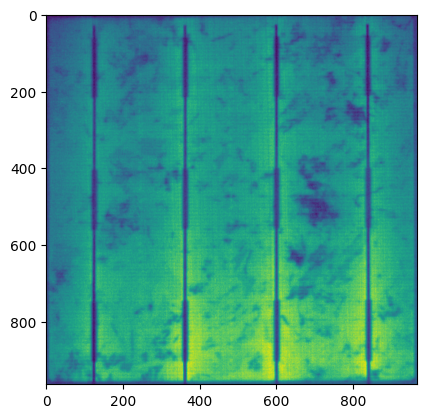

1/1 [==============================] - 0s 24ms/step


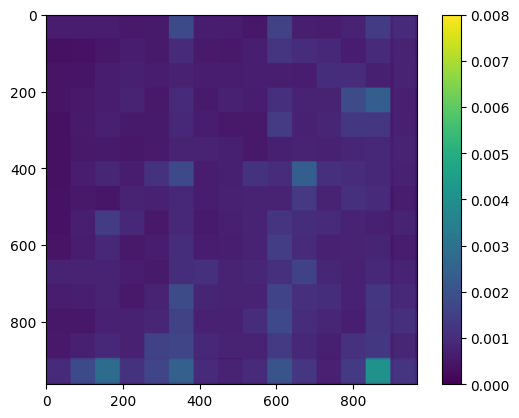

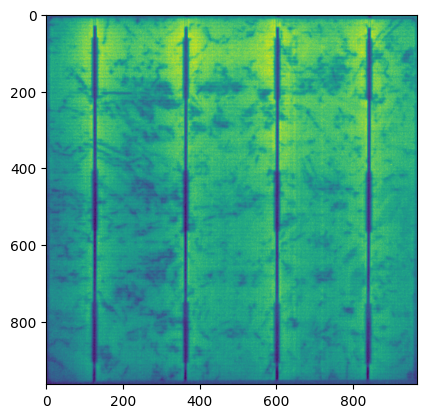

1/1 [==============================] - 0s 25ms/step


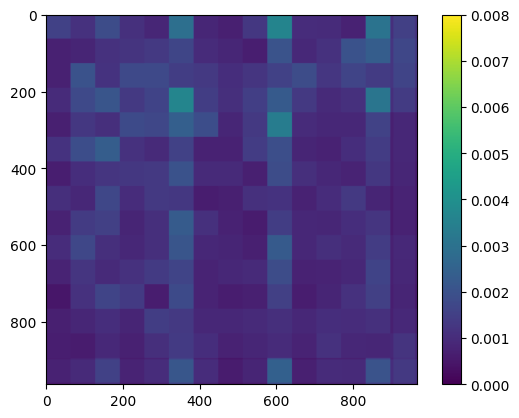

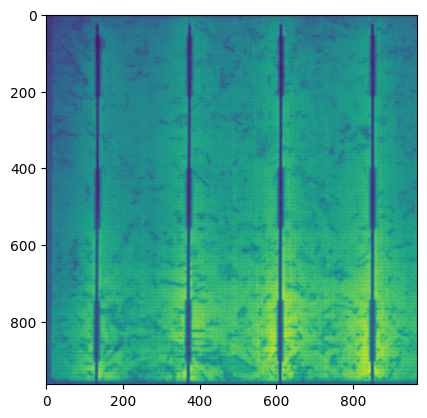

1/1 [==============================] - 0s 22ms/step


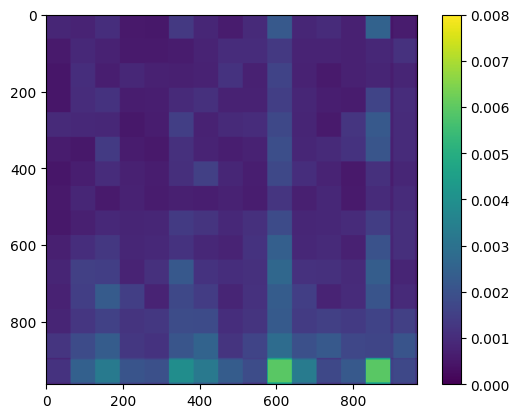

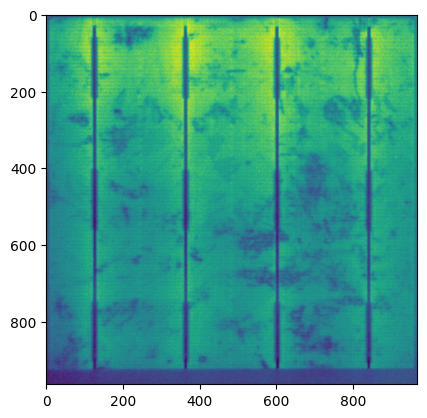

1/1 [==============================] - 0s 24ms/step


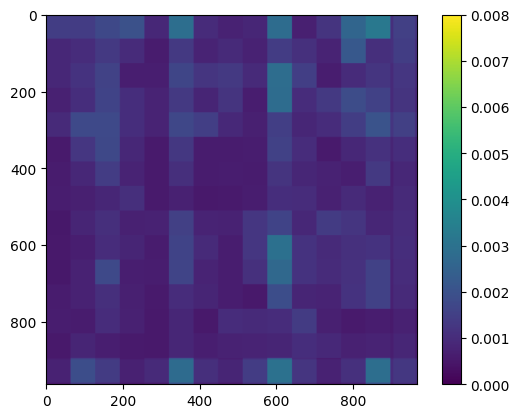

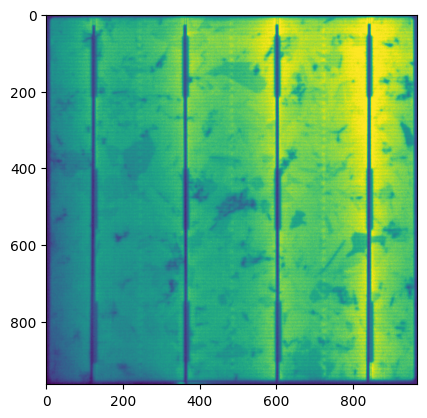

1/1 [==============================] - 0s 22ms/step


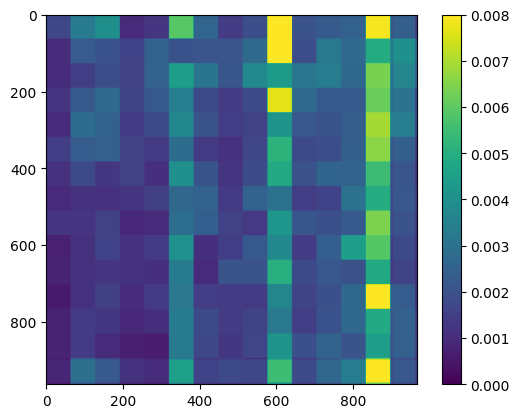

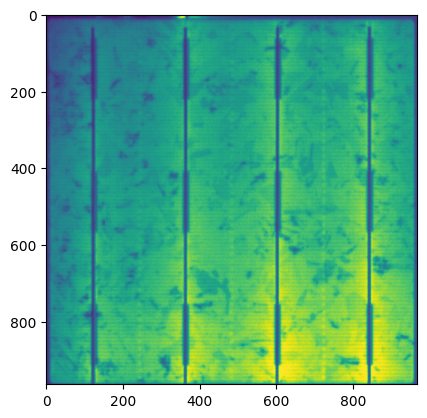

1/1 [==============================] - 0s 23ms/step


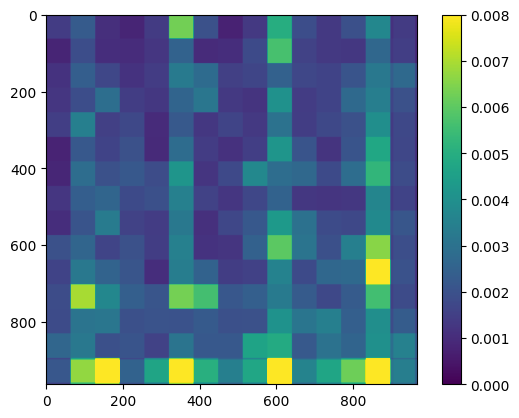

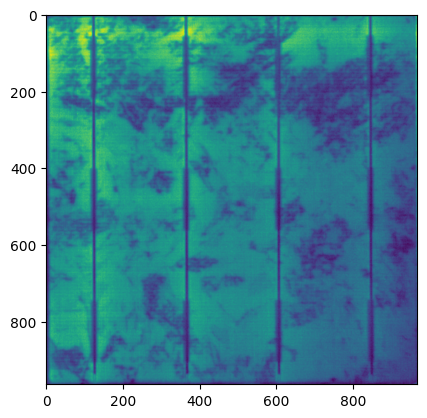

1/1 [==============================] - 0s 31ms/step


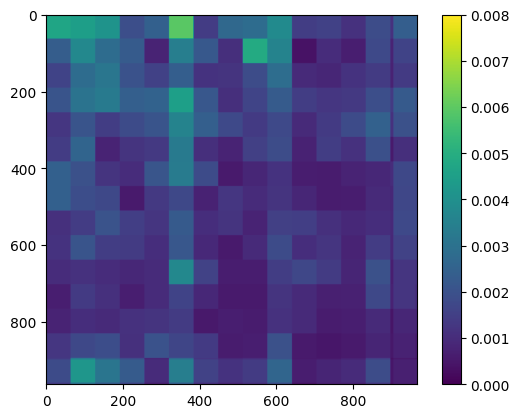

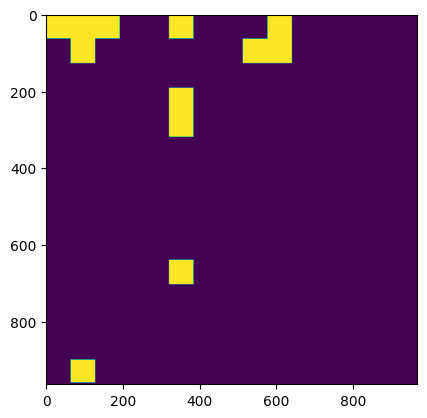

In [ ]:
threshold = 0.0035
for val,fname in enumerate(files_C[1:10]):
  or_img = cv2.imread(fname,0)
  plt.imshow(or_img)
  plt.show()
  #print(val, ' :: ', fname)
  prob_med = anomaly_det(fname,64,type='All')
  Error = prob_med>threshold
  plt.imshow(prob_med)
  plt.colorbar()
  plt.clim(0, 0.008)
  plt.show()
  plt.imshow(Error)
  plt.show